First, import data to compare (neuron 20 vs 45 for 'RoyMaze1' session from Hiro dataset).

In [72]:
from scipy.io import loadmat

filepath = '/data/Working/Other Peoples Data/HiroData/wake_new/wake-spikes.mat'
session = 'RoyMaze1'

mat_in = loadmat(filepath, squeeze_me=True, struct_as_record=False)

Organize data

In [73]:
neurons = [19, 44]
spikes_use = [mat_in['spikes'].RoyMaze1[neuron] for neuron in neurons]

In [74]:
import ccg
import numpy as np

time_to_sec = 1/(1000*1000)  # Hiro data times are in microseconds
spikes_unsorted = np.concatenate([a.time for a in spikes_use])*time_to_sec  # assemble spikes
clu_id = np.concatenate([[idc] * len(a.time) for idc, a in enumerate(spikes_use)])  # assemble cluster ids

# Now sort them for input to ccg function below
sort_ind = np.argsort(spikes_unsorted)
spikes = spikes_unsorted[sort_ind]
clu_id = clu_id[sort_ind]

Now, run ccg and plot it!

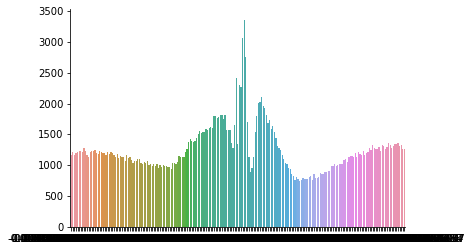

In [4]:
import seaborn as sns

# run ccg
window_size, bin_size = 0.007, 1/30000
ccgs = ccg.correlograms(spikes, clu_id, window_size=window_size, bin_size=bin_size, sample_rate=30000)

# plot ccg
bins = np.linspace(-window_size/2, window_size/2, num=int(window_size/bin_size + 1))
sns.barplot(x=bins, y=ccgs[1,0,:])
sns.despine()

Now time it! For reference, the same neuron-pair takes about 80ms in MATLAB. Maybe using cupy could help, but for now it should be fine.

In [5]:
%timeit ccg.correlograms(spikes, clu_id, window_size=window_size, bin_size=bin_size, sample_rate=30000)

131 ms ± 404 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Test out cupy on some simple operations on large arrays

In [4]:
import cupy as cp
import numpy as np
x_gpu = cp.array([1, 2, 3])
x_gpu*2

array([2, 4, 6])

In [11]:
%timeit cp.square(cp.ones((1000000,))*5)

206 µs ± 1.64 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
%timeit np.square(np.ones((1000000,))*5)

1.51 ms ± 2.52 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Now start building up infrastructure for doing stats on CCGs and plotting nicely!

In [14]:
cp.float3

numpy.float32

In [93]:
import cupy as cp


# ------------------------------------------------------------------------------
# Cross-correlograms
# ------------------------------------------------------------------------------
_ACCEPTED_ARRAY_DTYPES = (
    cp.float_,
    cp.float32,
    cp.float64,
    cp.int_,
    cp.int8,
    cp.int16,
    cp.uint8,
    cp.uint16,
    cp.int32,
    cp.int64,
    cp.uint32,
    cp.uint64,
    cp.bool_,
)


def _as_array(arr, dtype=None):
    """Convert an object to a numerical CuPy array.
    Avoid a copy if possible.
    """
    if arr is None:
        return None
    if isinstance(arr, cp.ndarray) and dtype is None:
        return arr
    if isinstance(arr, (int, float)):
        arr = [arr]
    out = cp.asarray(arr)
    if dtype is not None:
        if out.dtype != dtype:
            out = out.astype(dtype)
    if out.dtype not in _ACCEPTED_ARRAY_DTYPES:
        raise ValueError(
            "'arr' seems to have an invalid dtype: " "{0:s}".format(str(out.dtype))
        )
    return out


def _index_of(arr, lookup):
    """Replace scalars in an array by their indices in a lookup table.
    Implicitely assume that:
    * All elements of arr and lookup are non-negative integers.
    * All elements or arr belong to lookup.
    This is not checked for performance reasons.
    """
    # Equivalent of cp.digitize(arr, lookup) - 1, but much faster.
    # TODO: assertions to disable in production for performance reasons.
    # TODO: cp.searchsorted(lookup, arr) is faster on small arrays with large
    # values
    lookup = cp.asarray(lookup, dtype=cp.int32)
    m = int((lookup.max() if len(lookup) else 0) + 1)
    tmp = cp.zeros(m + 1, dtype=cp.int_)
    # Ensure that -1 values are kept.
    tmp[-1] = -1
    if len(lookup):
        tmp[lookup] = cp.arange(len(lookup))
    return tmp[arr]


def _unique(x):
    """Faster version of cp.unique().
    This version is restricted to 1D arrays of non-negative integers.
    It is only faster if len(x) >> len(unique(x)).
    """
    if x is None or len(x) == 0:
        return cp.array([], dtype=cp.int64)
    # WARNING: only keep positive values.
    # cluster=-1 means "unclustered".
    x = _as_array(x)
    x = x[x >= 0]
    bc = cp.bincount(x)
    return cp.nonzero(bc)[0]


def _increment(arr, indices):
    """Increment some indices in a 1D vector of non-negative integers.
    Repeated indices are taken into account."""
    arr = _as_array(arr)
    indices = _as_array(indices)
    bbins = cp.asarray(np.bincount(cp.asnumpy(indices)))  # NRK can you make this cupy? Maybe add in try/except statement?
    arr[: len(bbins)] += bbins
    return arr


def _diff_shifted(arr, steps=1):
    arr = _as_array(arr)
    return arr[steps:] - arr[: len(arr) - steps]


def _create_correlograms_array(n_clusters, winsize_bins):
    return cp.zeros((n_clusters, n_clusters, winsize_bins // 2 + 1), dtype=cp.int32)


def _symmetrize_correlograms(correlograms):
    """Return the symmetrized version of the CCG arrays."""

    n_clusters, _, n_bins = correlograms.shape
    assert n_clusters == _

    # We symmetrize c[i, j, 0].
    # This is necessary because the algorithm in correlograms()
    # is sensitive to the order of identical spikes.
    correlograms[..., 0] = cp.maximum(correlograms[..., 0], correlograms[..., 0].T)

    sym = correlograms[..., 1:][..., ::-1]
    sym = cp.transpose(sym, (1, 0, 2))

    return cp.dstack((sym, correlograms))


def firing_rate(spike_clusters, cluster_ids=None, bin_size=None, duration=None):
    """Compute the average number of spikes per cluster per bin."""

    # Take the cluster order into account.
    if cluster_ids is None:
        cluster_ids = _unique(spike_clusters)
    else:
        cluster_ids = _as_array(cluster_ids)

    # Like spike_clusters, but with 0..n_clusters-1 indices.
    spike_clusters_i = _index_of(spike_clusters, cluster_ids)

    assert bin_size > 0
    bc = cp.bincount(spike_clusters_i)
    # Handle the case where the last cluster(s) are empty.
    if len(bc) < len(cluster_ids):
        n = len(cluster_ids) - len(bc)
        bc = cp.concatenate((bc, cp.zeros(n, dtype=bc.dtype)))
    assert bc.shape == (len(cluster_ids),)
    return bc * cp.c_[bc] * (bin_size / (duration or 1.0))


def correlograms(
    spike_times,
    spike_clusters,
    cluster_ids=None,
    sample_rate=1.0,
    bin_size=None,
    window_size=None,
    symmetrize=True,
):
    """Compute all pairwise cross-correlograms among the clusters appearing
    in `spike_clusters`.
    Parameters
    ----------
    spike_times : array-like
        Spike times in seconds.
    spike_clusters : array-like
        Spike-cluster mapping.
    cluster_ids : array-like
        The list of *all* unique clusters, in any order. That order will be used
        in the output array.
    bin_size : float
        Size of the bin, in seconds.
    window_size : float
        Size of the window, in seconds.
    sample_rate : float
        Sampling rate.
    symmetrize : boolean (True)
        Whether the output matrix should be symmetrized or not.
    Returns
    -------
    correlograms : array
        A `(n_clusters, n_clusters, winsize_samples)` array with all pairwise CCGs.
    """
    assert sample_rate > 0.0
    assert cp.all(cp.diff(spike_times) >= 0), "The spike times must be " "increasing."

    # Get the spike samples.
    spike_times = cp.asarray(spike_times, dtype=cp.float64)
    spike_samples = (spike_times * sample_rate).astype(cp.int64)

    spike_clusters = _as_array(spike_clusters)

    assert spike_samples.ndim == 1
    assert spike_samples.shape == spike_clusters.shape

    # Find `binsize`.
    bin_size = np.clip(bin_size, 1e-5, 1e5)  # in seconds  # NRK can you make this cupy? does it matter?
    binsize = int(sample_rate * bin_size)  # in samples
    assert binsize >= 1

    # Find `winsize_bins`.
    window_size = np.clip(window_size, 1e-5, 1e5)  # in seconds  # NRK can you make this cupy? does it matter?
    winsize_bins = 2 * int(0.5 * window_size / bin_size) + 1

    assert winsize_bins >= 1
    assert winsize_bins % 2 == 1

    # Take the cluster order into account.
    if cluster_ids is None:
        clusters = _unique(spike_clusters)
    else:
        clusters = _as_array(cluster_ids)
    n_clusters = len(clusters)

    # Like spike_clusters, but with 0..n_clusters-1 indices.
    spike_clusters_i = _index_of(spike_clusters, clusters)

    # Shift between the two copies of the spike trains.
    shift = 1

    # At a given shift, the mask precises which spikes have matching spikes
    # within the correlogram time window.
    mask = cp.ones_like(spike_samples, dtype=cp.bool_)

    correlograms = _create_correlograms_array(n_clusters, winsize_bins)

    # The loop continues as long as there is at least one spike with
    # a matching spike.
    while mask[:-shift].any():
        # Number of time samples between spike i and spike i+shift.
        spike_diff = _diff_shifted(spike_samples, shift)

        # Binarize the delays between spike i and spike i+shift.
        spike_diff_b = spike_diff // binsize

        # Spikes with no matching spikes are masked.
        mask[:-shift][spike_diff_b > (winsize_bins // 2)] = False

        # Cache the masked spike delays.
        m = mask[:-shift].copy()
        d = spike_diff_b[m]

        # # Update the masks given the clusters to update.
        # m0 = cp.in1d(spike_clusters[:-shift], clusters)
        # m = m & m0
        # d = spike_diff_b[m]
        d = spike_diff_b[m]

        # Find the indices in the raveled correlograms array that need
        # to be incremented, taking into account the spike clusters.
        indices = cp.ravel_multi_index(
            (spike_clusters_i[:-shift][m], spike_clusters_i[+shift:][m], d),
            correlograms.shape,
        )

        # Increment the matching spikes in the correlograms array.
        _increment(correlograms.ravel(), indices)

        shift += 1

    if symmetrize:
        return _symmetrize_correlograms(correlograms)
    else:
        return correlograms



Test each function above.

In [67]:
arr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40]
lookup = [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20, 30, 40, 45, 50]]
indices = [0, 5, 10]
# _unique(np.random.randint(0, 5000, 100))
# _increment(arr, indices)
# _diff_shifted(arr, steps=3)
# _symmetrize_correlograms(_create_correlograms_array(2, 51))
firing_rate([1,2,1,2,1,2,1,1,1,1,1,1,1,1,2], cluster_ids=[1,2], bin_size=2)

array([[242.,  88.],
       [ 88.,  32.]])

Ok, now do the real test on actual data to 1) make sure it spits out the same answer, and then 2) compare speeds.

<IPython.core.display.Javascript object>


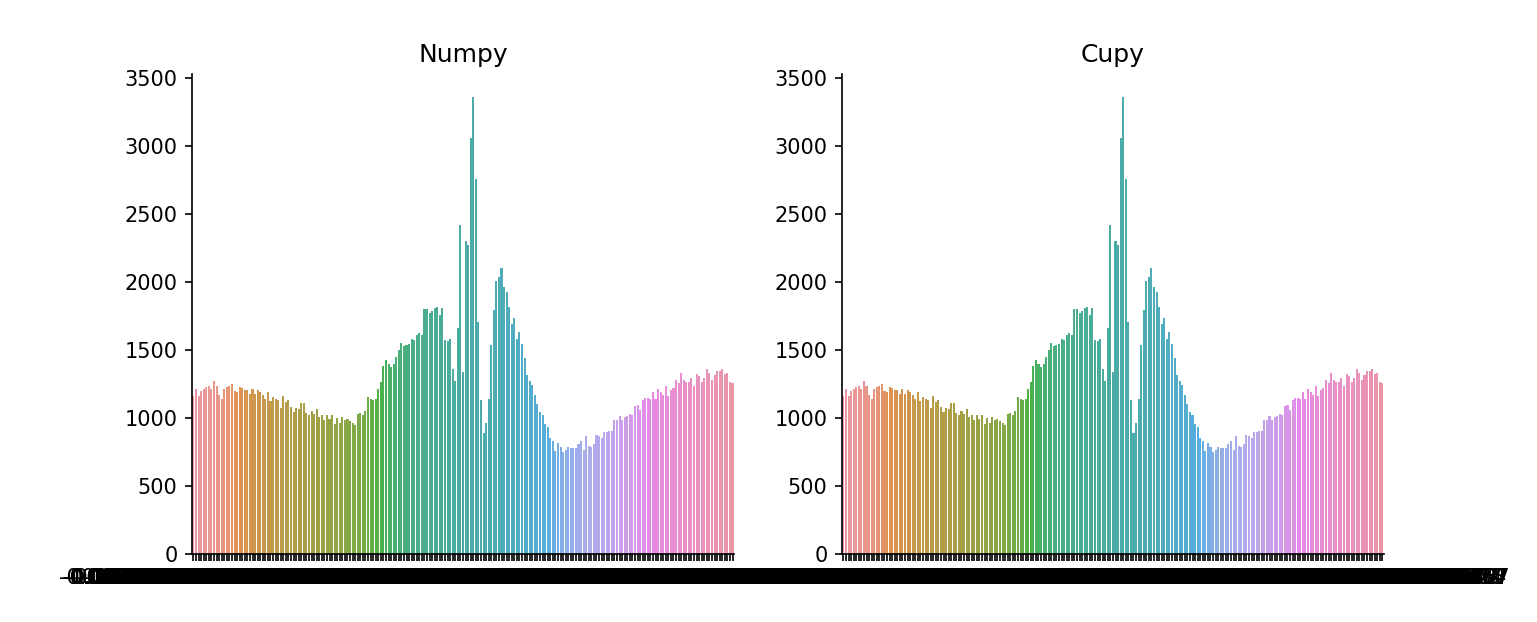

Text(0.5, 1.0, 'Cupy')

In [104]:
%matplotlib notebook

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2)
fig.set_size_inches([7.5, 3.0])

# run ccg
window_size, bin_size = 0.007, 1/30000
ccgs = ccg.correlograms(spikes, clu_id, window_size=window_size, bin_size=bin_size, sample_rate=30000)

# plot ccg
bins = np.linspace(-window_size/2, window_size/2, num=int(0.007/bin_size + 1))
sns.barplot(x=bins, y=ccgs[1,0,:], ax = ax[0])
sns.despine()
ax[0].set_title('Numpy')

# run ccg
window_size, bin_size = 0.007, 1/30000
ccgs_cu = cp.asnumpy(correlograms(spikes, clu_id, window_size=window_size, bin_size=bin_size, sample_rate=30000))

# plot ccg
bins = np.linspace(-window_size/2, window_size/2, num=int(0.007/bin_size + 1))
sns.barplot(x=bins, y=ccgs_cu[1,0,:], ax = ax[1])
sns.despine()
ax[1].set_title('Cupy')

The CCGs appear exactly the same when zoomed in, though if you zoom out it can lead you to believe they are slightly different due to screen resolution issues.

In [96]:
%timeit ccg.correlograms(spikes, clu_id, window_size=window_size, bin_size=bin_size, sample_rate=30000)

149 ms ± 476 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [97]:
%timeit correlograms(spikes, clu_id, window_size=window_size, bin_size=bin_size, sample_rate=30000)

22.6 ms ± 239 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Ok awesome, I get an 8x speedup from numpy alone and a 4x speedup from the CCGheart.c mex MATLAB file (80ms for the same cell-pair, without parallelization in MATLAB though).

Numpy implementation of `correlograms` below for reference.

In [ ]:
import numpy as np

# ------------------------------------------------------------------------------
# Cross-correlograms
# ------------------------------------------------------------------------------
_ACCEPTED_ARRAY_DTYPES = (
    np.float,
    np.float32,
    np.float64,
    np.int,
    np.int8,
    np.int16,
    np.uint8,
    np.uint16,
    np.int32,
    np.int64,
    np.uint32,
    np.uint64,
    np.bool,
)


def _as_array(arr, dtype=None):
    """Convert an object to a numerical NumPy array.
    Avoid a copy if possible.
    """
    if arr is None:
        return None
    if isinstance(arr, np.ndarray) and dtype is None:
        return arr
    if isinstance(arr, (int, float)):
        arr = [arr]
    out = np.asarray(arr)
    if dtype is not None:
        if out.dtype != dtype:
            out = out.astype(dtype)
    if out.dtype not in _ACCEPTED_ARRAY_DTYPES:
        raise ValueError(
            "'arr' seems to have an invalid dtype: " "{0:s}".format(str(out.dtype))
        )
    return out


def _index_of(arr, lookup):
    """Replace scalars in an array by their indices in a lookup table.
    Implicitely assume that:
    * All elements of arr and lookup are non-negative integers.
    * All elements or arr belong to lookup.
    This is not checked for performance reasons.
    """
    # Equivalent of np.digitize(arr, lookup) - 1, but much faster.
    # TODO: assertions to disable in production for performance reasons.
    # TODO: np.searchsorted(lookup, arr) is faster on small arrays with large
    # values
    lookup = np.asarray(lookup, dtype=np.int32)
    m = (lookup.max() if len(lookup) else 0) + 1
    tmp = np.zeros(m + 1, dtype=np.int)
    # Ensure that -1 values are kept.
    tmp[-1] = -1
    if len(lookup):
        tmp[lookup] = np.arange(len(lookup))
    return tmp[arr]


def _unique(x):
    """Faster version of np.unique().
    This version is restricted to 1D arrays of non-negative integers.
    It is only faster if len(x) >> len(unique(x)).
    """
    if x is None or len(x) == 0:
        return np.array([], dtype=np.int64)
    # WARNING: only keep positive values.
    # cluster=-1 means "unclustered".
    x = _as_array(x)
    x = x[x >= 0]
    bc = np.bincount(x)
    return np.nonzero(bc)[0]


def _increment(arr, indices):
    """Increment some indices in a 1D vector of non-negative integers.
    Repeated indices are taken into account."""
    arr = _as_array(arr)
    indices = _as_array(indices)
    bbins = np.bincount(indices)
    arr[: len(bbins)] += bbins
    return arr


def _diff_shifted(arr, steps=1):
    arr = _as_array(arr)
    return arr[steps:] - arr[: len(arr) - steps]


def _create_correlograms_array(n_clusters, winsize_bins):
    return np.zeros((n_clusters, n_clusters, winsize_bins // 2 + 1), dtype=np.int32)


def _symmetrize_correlograms(correlograms):
    """Return the symmetrized version of the CCG arrays."""

    n_clusters, _, n_bins = correlograms.shape
    assert n_clusters == _

    # We symmetrize c[i, j, 0].
    # This is necessary because the algorithm in correlograms()
    # is sensitive to the order of identical spikes.
    correlograms[..., 0] = np.maximum(correlograms[..., 0], correlograms[..., 0].T)

    sym = correlograms[..., 1:][..., ::-1]
    sym = np.transpose(sym, (1, 0, 2))

    return np.dstack((sym, correlograms))


def firing_rate(spike_clusters, cluster_ids=None, bin_size=None, duration=None):
    """Compute the average number of spikes per cluster per bin."""

    # Take the cluster order into account.
    if cluster_ids is None:
        cluster_ids = _unique(spike_clusters)
    else:
        cluster_ids = _as_array(cluster_ids)

    # Like spike_clusters, but with 0..n_clusters-1 indices.
    spike_clusters_i = _index_of(spike_clusters, cluster_ids)

    assert bin_size > 0
    bc = np.bincount(spike_clusters_i)
    # Handle the case where the last cluster(s) are empty.
    if len(bc) < len(cluster_ids):
        n = len(cluster_ids) - len(bc)
        bc = np.concatenate((bc, np.zeros(n, dtype=bc.dtype)))
    assert bc.shape == (len(cluster_ids),)
    return bc * np.c_[bc] * (bin_size / (duration or 1.0))


def correlograms(
    spike_times,
    spike_clusters,
    cluster_ids=None,
    sample_rate=1.0,
    bin_size=None,
    window_size=None,
    symmetrize=True,
):
    """Compute all pairwise cross-correlograms among the clusters appearing
    in `spike_clusters`.
    Parameters
    ----------
    spike_times : array-like
        Spike times in seconds.
    spike_clusters : array-like
        Spike-cluster mapping.
    cluster_ids : array-like
        The list of *all* unique clusters, in any order. That order will be used
        in the output array.
    bin_size : float
        Size of the bin, in seconds.
    window_size : float
        Size of the window, in seconds.
    sample_rate : float
        Sampling rate.
    symmetrize : boolean (True)
        Whether the output matrix should be symmetrized or not.
    Returns
    -------
    correlograms : array
        A `(n_clusters, n_clusters, winsize_samples)` array with all pairwise CCGs.
    """
    assert sample_rate > 0.0
    assert np.all(np.diff(spike_times) >= 0), "The spike times must be " "increasing."

    # Get the spike samples.
    spike_times = np.asarray(spike_times, dtype=np.float64)
    spike_samples = (spike_times * sample_rate).astype(np.int64)

    spike_clusters = _as_array(spike_clusters)

    assert spike_samples.ndim == 1
    assert spike_samples.shape == spike_clusters.shape

    # Find `binsize`.
    bin_size = np.clip(bin_size, 1e-5, 1e5)  # in seconds
    binsize = int(sample_rate * bin_size)  # in samples
    assert binsize >= 1

    # Find `winsize_bins`.
    window_size = np.clip(window_size, 1e-5, 1e5)  # in seconds
    winsize_bins = 2 * int(0.5 * window_size / bin_size) + 1

    assert winsize_bins >= 1
    assert winsize_bins % 2 == 1

    # Take the cluster order into account.
    if cluster_ids is None:
        clusters = _unique(spike_clusters)
    else:
        clusters = _as_array(cluster_ids)
    n_clusters = len(clusters)

    # Like spike_clusters, but with 0..n_clusters-1 indices.
    spike_clusters_i = _index_of(spike_clusters, clusters)

    # Shift between the two copies of the spike trains.
    shift = 1

    # At a given shift, the mask precises which spikes have matching spikes
    # within the correlogram time window.
    mask = np.ones_like(spike_samples, dtype=np.bool)

    correlograms = _create_correlograms_array(n_clusters, winsize_bins)

    # The loop continues as long as there is at least one spike with
    # a matching spike.
    while mask[:-shift].any():
        # Number of time samples between spike i and spike i+shift.
        spike_diff = _diff_shifted(spike_samples, shift)

        # Binarize the delays between spike i and spike i+shift.
        spike_diff_b = spike_diff // binsize

        # Spikes with no matching spikes are masked.
        mask[:-shift][spike_diff_b > (winsize_bins // 2)] = False

        # Cache the masked spike delays.
        m = mask[:-shift].copy()
        d = spike_diff_b[m]

        # # Update the masks given the clusters to update.
        # m0 = np.in1d(spike_clusters[:-shift], clusters)
        # m = m & m0
        # d = spike_diff_b[m]
        d = spike_diff_b[m]

        # Find the indices in the raveled correlograms array that need
        # to be incremented, taking into account the spike clusters.
        indices = np.ravel_multi_index(
            (spike_clusters_i[:-shift][m], spike_clusters_i[+shift:][m], d),
            correlograms.shape,
        )

        # Increment the matching spikes in the correlograms array.
        _increment(correlograms.ravel(), indices)

        shift += 1

    if symmetrize:
        return _symmetrize_correlograms(correlograms)
    else:
        return correlograms
